In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<ErrorbarContainer object of 3 artists>

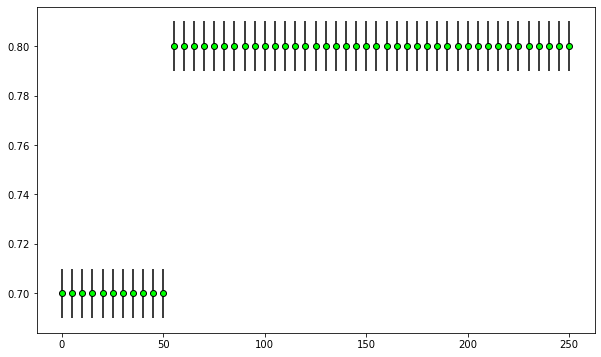

In [67]:
path = '/Users/ctlewis/Library/Mobile Documents/com~apple~CloudDocs/Documents/Programs_Coding/to_JL.xlsx'
sheet = 'Sheet1'
sheetII = 'Sheet2'

# import dataset
data_costa = pd.read_excel(path,
                     sheet_name=sheet)

data_costaII = pd.read_excel(path,
                     sheet_name=sheetII)

# turn the data of interest into a 1D array
Fo = data_costa.Fo
FoII = data_costaII.Fo
unc = 0.01 #uncertainty (please propogate)

# set the resolution of your data (distance between spots) 
resolution = 5 # um
L = np.linspace(0,(len(Fo)-1)*resolution,len(Fo)) # an array containing x data from start to finish
                                                  # This is used for setting up your mesh later
#plot measured profile
fig,ax = plt.subplots(figsize=(10,6))
ax.errorbar(L,Fo,yerr=unc,fmt='o',mfc='lime',mec='k',ecolor='k')

In [68]:
xth_spot = 11 # spots from the interior point to where you want your initial step function to be (python starts counting at 0)
x_core = L[xth_spot] # core side
dx = resolution
x_core_mesh = int(x_core/dx) # the ith point in your x-value mesh that will diffuse

C_core = Fo[xth_spot-1] # core side concentration
C_rim = Fo[xth_spot] # rim side concentration

#initial condition
u_n = np.zeros(len(L)) # Creates an array of appropriate size to set your initial condition for concentration
                        # This is u at the t-1 (i.e., previous) time. Also used to set initial condition
u_n[:x_core_mesh] = 0.7 # Set a constant concentration on the core side of the crystal
u_n[x_core_mesh:] = C_rim # Set a constant concentration on the rim side of the crystal

def get_initialprofile(Fo,resolution,x_thspot):
    """
    """
    L = np.linspace(0,(len(Fo)-1)*resolution,len(Fo))
    x_core = L[xth_spot]
    dx = resolution
    x_core_mesh = int(xcore/dx)
    C_core = Fo[xth_spot-1]
    C_rim = Fo[xth_spot]
    u_n = np.zeros(len(L))
    u_n[:x_core_mesh] = C_core
    u_n[x_core_mesh:] = C_rim
    
    return u_n

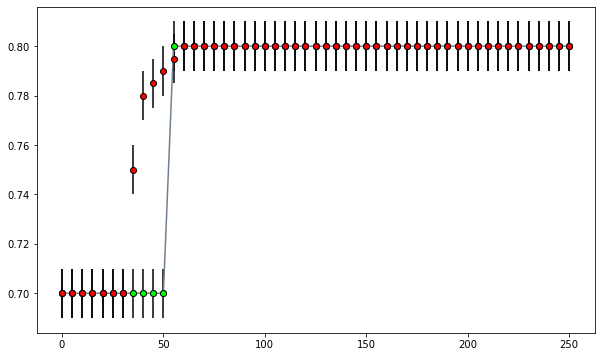

In [69]:
# plot your data and the initial profile
fig,ax = plt.subplots(figsize=(10,6))
ax.errorbar(L,Fo,yerr=unc,fmt='o',mfc='lime',mec='k',ecolor='k')
ax.errorbar(L,FoII,yerr=unc,fmt='o',mfc='red',mec='k',ecolor='k')
ax.plot(L,u_n,'-',marker='o',color='slategray')

In [70]:
R = 8.3144 # Gas constant J K^-1 mol^-1
T = (1200.0+273) # Temperature (K)
Do = 10**(-9.21) # Initial Diffusion Coefficient m^2 s^-1
E = 201000.0 # Activiation Energy J mol-1
fo2 = 10**(-12) # fo2 in bar

def diff_coef(Do, E, R, T, u_n):
    """
    Calculate the diffusion coefficient
    Assumed to follow an Arrhenius equations with a pre-exponential
    for fo2. With corrections for units included, this goes as:
    
    Di = Do * [(fo2/10e-12)^(1/6) * 10^(3*(0.9-Ci)) * e^(-E/(R*10^(-3/T)))] * 10e12
    
    Do: Initial diffusion coefficent (m2 s-1)
    E: Activation Energy (J mol-1)
    R: Gas Constant (J K-1 mol-1)
    T: Temperature (K)
    fo2: Proportional to Pressure (bar)
    
    u_n: Initial data profile
    
    Returns Di in µ^2 / s-1
    
    """ 
    Di = ((Do*((fo2/10e-7)**(1/6))*(10**(3*((1-u_n)-0.1)))*np.exp(-E/(R*T))))*10e12
    return Di

Di = diff_coef(Do,E,R,T,u_n)

In [71]:
# set up your time mesh that you will use to run the diffusion model
def time_mesh(maxtime,iterations,timeunit='years'):
    """
    Create a time mesh for your model.
    Function converts your chosen unit into seconds in order to keep units consistent in
    the function below.
    
    Inputs:
    maxtime: The maximum amount of time you want the model to run
    iterations: How many steps you want between the start time and Maxtime.
    timeunit: The unit you used in the inputs above
    
    Returns
    t: a 1D array that has your maxtime split by n+1 interations
    """
    if timeunit == 'years':
        step = 60 * 60 * 24 * 365.25
    elif timeunit == 'months':
        step = (60 * 60 * 24 * 365.25)/12
    elif timeunit == 'days':
        step = 60 * 60 * 24
    elif timeunit == 'hours':
        step = (60 * 60 * 24 * 365.25)/8760
    elif timeunit == 'seconds':
        step = (60 * 60 * 24 * 365.25)/3.154e7
    
    t = np.linspace(0,maxtime*step,int(iterations+1))
    return t

In [72]:
t = time_mesh(6780000,(6780000/60000),'seconds')

In [73]:
R = 8.3144 # Gas constant J K^-1 mol^-1
T = (1200.0+273) # Temperature (K)
Do = 10**(-9.21) # Initial Diffusion Coefficient m^2 s^-1
E = 201000.0 # Activiation Energy J mol-1
fo2 = 10**(-12) # fo2 in bar

def diff_coef(Do, E, R, T, u_n):
    """
    Calculate the diffusion coefficient
    Assumed to follow an Arrhenius equations with a pre-exponential
    for fo2. With corrections for units included, this goes as:
    
    Di = Do * [(fo2/10e-12)^(1/6) * 10^(3*(0.9-Ci)) * e^(-E/(R*10^(-3/T)))] * 10e12
    
    Do: Initial diffusion coefficent (m2 s-1)
    E: Activation Energy (J mol-1)
    R: Gas Constant (J K-1 mol-1)
    T: Temperature (K)
    fo2: Proportional to Pressure (bar)
    
    u_n: Initial data profile
    
    Returns Di in µ^2 / s-1
    
    """ 
    Di = ((Do*((fo2/10e-7)**(1/6))*(10**(3*((1-u_n)-0.1)))*np.exp(-E/(R*T))))*10e12
    return Di

Di = diff_coef(Do,E,R,T,u_n)

In [74]:
def olivine_diffusion_1D(Fo,resolution,xth_spot,t,Do,E,R,T,boundary='closed',C_core='default',C_rim='default'):
    """
    Run a 1D olivine diffusion model based on a forward Euler scheme with a boundary condition determined by the user.
    In the simplest since, the model solves u for matrices of type A * u = b, 
    where u is unknown, A is a matrix of mesh points in the x (nx) and time (nt) dimensions, 
    and b is vector of knowns that gets updated as time moves forward.
    
    The forward Euler scheme is the forward finite difference scheme of Fick's second law:
    
    d/dt C(x,t) = D d/dx^2 C(x,t)
    
    where t is time, x is distance, D is the diffusion coefficient, and C(x,t) is the concentration as a function
    of distance and time. If you wish to have an open boundary with the diffiusion coefficient dependent on the
    concentration, this goes as:
    
    d/dt C(x,t) = d/dx D d/dx C(x,t) + D d/dx^2 C(x,t)
    
    Inputs:
    Fo: Slice of a Pandas dataframe or python list containing your olivine data
    Resolution: Distance between measurements on your crystal (µm)
    xth_spot: The spot from the interior (core) point where you want the step function to be located. Note python
              starts counting at zero.
    t: A 1d array that is output from the time_mesh function above
    Do: The measured diffusion coefficent (m s^-2)
    E: Activation energy (J mol^-1)
    R: Gas Constant (J K^-1 mol^-1)
    T: Temperature (K)
    fo2: Proportional to pressure (bar)
    u_n: Initial data profile output from the function above
    boundary: Closed or open. See equations above. Default is closed.
    C_core: Boundary condition for the concentration at the core side of your crystal. If you input a value, this is
            the boundary condition for recalculating Di at each timestep. The default is the Fo concentration at the
            x_thspot you input above
    C_rim: Similar to C_core but for the next distance step forward.
    
    Returns:
    F: The mesh Fourier number. This is a measure of your numerical stability. You will get an error warning you if
       the numerical model is unstable.
    solutions: A set of numpy arrays containing the concentration solution for each timestep
    Di_arrays: A set of numpy arrays containing the solutions to the Di at each timestep
    """
    Fo = Fo.to_numpy() # Fo content for olivine

    L = np.linspace(0,(len(Fo)-1)*resolution,len(Fo))
    nx = len(L)
    dx = L[1] - L[0]
    x_core = L[xth_spot]
    x_core_mesh = int(x_core/dx)
    
    dt = t[1] - t[0]
    iterations = len(t)-1
    nt = len(t)
    
    solutions = np.zeros((nt,nx))
    Di_arrays = np.zeros((nt,nx))
    u = np.zeros(len(L))
    
    if boundary == 'closed':
        if C_core == 'default':
            C_core = Fo[xth_spot-1]
        elif C_core > 0:
            Fo[0] = C_core
        if C_rim == 'default':
            C_rim = Fo[xth_spot]
        elif C_rim > 0:
            Fo[-1] = C_rim
        
        u_n = np.zeros(len(L))
        u_n[:x_core_mesh] = C_core
        u_n[x_core_mesh:] = C_rim
        
        Di = ((Do*((fo2/10e-7)**(1/6))*(10**(3*((1-u_n)-0.1)))*np.exp(-E/(R*T))))*10e12
        
        for i in range(0,int(nt)):
            import time; t0 = time.perf_counter()
            u[1:nx-1] = u_n[1:nx-1] + ((Di[2:nx]-Di[1:nx-1])*(u_n[2:nx]-u_n[1:nx-1])+Di[1:nx-1]*(u_n[2:nx]-2*u_n[1:nx-1]+u_n[0:nx-2]))*(dt/(dx**2))
            u[0] = C_core; u[-1] = C_rim
            solutions[i,:] = u
            u_n[:] = u
            t1 = time.perf_counter()
    elif boundary == 'open':
        Fo[0] = C_core
        Fo[-1] = C_rim
        
        u_n = np.zeros(len(L))
        u_n[:x_core_mesh] = C_core
        u_n[x_core_mesh:] = C_rim
        
        Di = ((Do*((fo2/10e-7)**(1/6))*(10**(3*((1-u_n)-0.1)))*np.exp(-E/(R*T))))*10e12
        
        for i in range(0,int(nt)):
            import time; t0 = time.perf_counter()
            u[1:nx-1] = u_n[1:nx-1] + ((Di[2:nx]-Di[1:nx-1])*(u_n[2:nx]-u_n[1:nx-1])+Di[1:nx-1]*(u_n[2:nx]-2*u_n[1:nx-1]+u_n[0:nx-2]))*(dt/(dx**2))
            u[0] = C_core; u[-1] = C_rim
            solutions[i,:] = u
            u_n[:] = u
            Di = ((Do*((fo2/10e-7)**(1/6))*(10**(3*((1-u)-0.1)))*np.exp(-E/(R*T))))*10e12
            Di_arrays[i,:] = Di
            t1 = time.perf_counter()

    F = max(Di)*dt/dx**2
    if F > 0.5:
        print('Mesh Fourier Number is too high causing instability in the model. Decrease dt')

    return solutions, F, Di_arrays

In [75]:
# def olivine_diffusion_1D(Fo,resolution,xth_spot,t,Do,E,R,T,u_n,boundary='closed',C_core='default',C_rim='default'):

# def diff_coef(Do, E, R, T, u_n):
R = 8.3144 # Gas constant J K^-1 mol^-1
T = (1200.0+273) # Temperature (K)
Do = 10**(-9.21) # Initial Diffusion Coefficient m^2 s^-1
E = 201000.0 # Activiation Energy J mol-1
fo2 = 10**(-12) # fo2 in bar

#%timeit F, solutions, Di_arrays = olivine_diffusion_1D(Fo,5,11,t,Do,E,R,T,u_n,boundary='closed')
solutions, F, Di_arrays = olivine_diffusion_1D(FoII,5,11,t,Do,E,R,T,boundary='closed',C_core=0.7,C_rim=0.8)

In [76]:
def least_squaredresiduals(solutions,Fo):
    """
    Function for finding the best fit by least squared residuals
    ---
    Inputs:
    solutions: numpy array output from the diffusion model
    Fo: your data. Same input as that you used for the diffusion model
    """
    
    from scipy.signal import argrelextrema # import package to find local minima / maxima
    
    L = np.linspace(0,(len(Fo)-1)*resolution,len(Fo)) # make an array
    nx = len(L) # set the length over which you will calculate the least squares
    
    least_residuals_fit = np.zeros_like(solutions) # make an array of zeros to be filled by the function below
    
    # make a loop to calculate the least squares. this iterates through all sets of solutions (i) that were calculated
    # at time t_i along the length of your diffusion profile (nx, above; defined as the kth spot below)
    for i in range(0,len(solutions)):
        for k in range(0,int(nx)):
            least_residuals_fit[i,k] = (solutions[i,k]-Fo[k])**2 / Fo[k]
    
    summed_residuals = np.sum(least_residuals_fit,axis=1) # sum calculated squared residuals along the length of solutions
    min_residuals = np.min(summed_residuals) # find the solution with the minimum residual
    locbestfit = np.argwhere(summed_residuals == min_residuals).item() # locate which solution that is
    bestfit_solution = solutions[locbestfit] # set that solution as the 'best fit solution'
    
    # Flag your solution sets to see if there are local minima. May need to make a judgement call if so
    localminima = summed_residuals[argrelextrema(summed_residuals, np.less)[0]]
    if len(localminima) > 1:
        print('You have more than one minima. You need to manually check all local minima to determine best fit')
    
    return min_residuals, bestfit_solution, locbestfit, summed_residuals, localminima

#%timeit min_residuals, bestfit_solution, locbestfit, summed_residuals, localminima = least_squaredresiduals(solutions,Fo)
min_residuals, bestfit_solution, locbestfit, summed_residuals, localminima = least_squaredresiduals(solutions,FoII)

1080602.6632847178

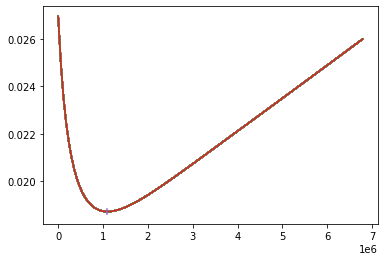

In [77]:
for i in range(0,len(summed_residuals)):
    plt.plot(t,summed_residuals)
plt.plot([t[locbestfit],t[locbestfit]],[min(summed_residuals)-0.0001,min(summed_residuals)+0.0001],'-')
#plt.ylim(0.038,0.042)
#plt.xlim(0,1e6)
t[locbestfit]

In [78]:
print(solutions)

[[0.7        0.7        0.7        ... 0.8        0.8        0.8       ]
 [0.7        0.7        0.7        ... 0.8        0.8        0.8       ]
 [0.7        0.7        0.7        ... 0.8        0.8        0.8       ]
 ...
 [0.7        0.70372233 0.70744943 ... 0.8        0.8        0.8       ]
 [0.7        0.70372442 0.70745319 ... 0.8        0.8        0.8       ]
 [0.7        0.70372633 0.70745658 ... 0.8        0.8        0.8       ]]


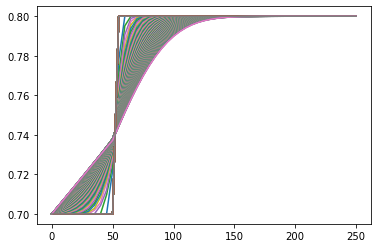

In [79]:
for i in range(0,len(solutions)):
    plt.plot(L,solutions[i,:])
    plt.plot(L,Fo)

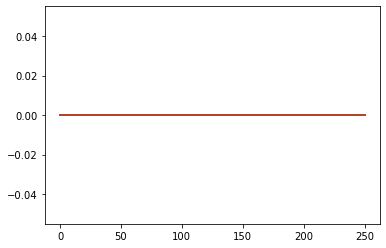

In [80]:
for i in range(0,len(Di_arrays)):
    plt.plot(L,Di_arrays[i,:])
    #plt.plot(L,Fo)